<a href="https://colab.research.google.com/github/anhphong22/ML_Implementation/blob/master/Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Baseline Model**
#1. [Detection]
**Dataset**
- No external data (optional: CheXNet public data)
- Image resolution: 512 x 512
- Abnormal images (remove class 14: `No finding`)

**Model**
- SSD 512
- use this repo: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection
- encoder: VGG16 (pytorch model zoo pretrained)

**Train**
- Single fold
- Augmentation: hflip, scale, shift, random brightness/ contrast
- Cls loss: focal loss, regression loss: l1
- Epochs: 60
- Optimizer: Adam (Optional: CrossEntropy)
- Scheduler: cosine annealing

#2. [Classification]
Note: classify the abnormal images

#Reference
http://cs230.stanford.edu/projects_winter_2021/reports/70750031.pdf





#**Pipeline**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CV02_Chest_X-RAY'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['chest_X-ray', '.ipynb_checkpoints', 'chest-xray-dataset.zip', 'vinbigdata', 'module', 'Detection.ipynb']


In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ['TZ'] = "Asia/Kolkata"
time.tzset()


In [5]:
import pandas as pd 
import numpy as np


import torch
import torchvision
from torchvision.ops.boxes import batched_nms
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 14

In [6]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU')

Good to go!


# Load the chest X-RAY dataset

In [7]:
from module.data import image_storage

In [8]:
phase = 'train'
image_storage = image_storage(phase)

In [ ]:
from google.colab.patches import cv2_imshow
from skimage import io
img = io.imread('/content/drive/MyDrive/CV02_Chest_X-RAY/vinbigdata/train/00053190460d56c53cc3e57321387478.png')

In [10]:
def read_data(data_root, phase):
  target= "".join([phase, ".csv"])
  data_path = os.path.join(data_root, target)
  target_df = pd.read_csv(data_path)
  return target_df


# Part I: Pre-Processing and Exploratory Analysis of the Training Data

In [11]:
data_root = '/content/drive/MyDrive/CV02_Chest_X-RAY/vinbigdata'
phase = 'train'
train_df = read_data(data_root, phase)

In [12]:
train_df = train_df[train_df.class_id != 14].reset_index(drop= True)
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353
...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,2304,2880
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0,3072,3072
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,2048,2500
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0,2304,2880


#Yolo v5

In [14]:
# check gpu
!nvidia-smi

Fri Sep 24 12:54:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
!pip install -r /content/drive/MyDrive/CV02_Chest_X-RAY/yolov5/requirements.txt

     |████████████████████████████████| 636 kB 5.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [16]:
!pip install timm

     |████████████████████████████████| 376 kB 4.4 MB/s 


## Import Libraries

In [23]:
pip install iterative-stratification

In [26]:
!pip install ensemble_boxes

In [33]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [35]:
pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=05b7f5bd42e5e1adc1021c0dff20bb53cefd4b63aa42f0b76742ca58a23348ea
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [36]:
import sys
sys.path.extend(['../input/effdet/',
                 '../input/iterstrat/',
                 '../input/weightedboxfusion/',
                 '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master/'])
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

from pathlib import Path
import os
import logging
from glob import glob

import json
import random 
import gc
import warnings

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import shutil as sh
from itertools import product
from collections import OrderedDict

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from ensemble_boxes import nms, weighted_boxes_fusion
import torchvision.transforms as transforms
import albumentations as al
from albumentations import ImageOnlyTransform
import albumentations.pytorch.transforms 
from albumentations.core.transforms_interface import DualTransform, ImageOnlyTransform

import cv2
import pydicom
from IPython.display import display, Image
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold
import torch
from torch.nn import functional as f
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, sampler
import timm
from efficientnet_pytorch import EfficientNet

pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s +++ %(message)s',
                    datefmt='%d-%m-%y %H:%M:%S', level=logging.INFO)
logger = logging.getLogger()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(device)

24-09-21 13:09:45 +++ cuda


In [37]:
os.environ["WANDB_API_KEY"] = '8f435998b1a6f9a4e59bfaef1deed81c1362a97d'
os.environ["WANDB_MODE"] = "dryrun"

MAIN_PATH = '../input/vinbigdata-chest-xray-abnormalities-detection/'
CLASSIFIER_MAIN_PATH = '../input/efficientnet-pytorch/'
RESIZE_1024_PATH = '../input/vinbigdata-chest-xray-resized-png-1024x1024/'
RESIZE_512_PATH = '../input/vinbigdata/'
TRAIN_PATH = os.path.join(MAIN_PATH, 'train.csv')
SUB_PATH = os.path.join(MAIN_PATH, 'sample_submission.csv')
TRAIN_DICOM_PATH = os.path.join(MAIN_PATH, 'train')
TEST_DICOM_PATH = os.path.join(MAIN_PATH, 'test')
TRAIN_1024_PATH = os.path.join(RESIZE_1024_PATH, 'train')
TEST_1024_PATH = os.path.join(RESIZE_1024_PATH, 'test')
TRAIN_512_PATH = os.path.join(RESIZE_512_PATH, 'train')
TEST_512_PATH = os.path.join(RESIZE_512_PATH, 'test')
TRAIN_META_PATH = os.path.join(RESIZE_1024_PATH, 'train_meta.csv')
TEST_META_PATH = '../input/vinbigdata-testmeta/test_meta.csv'
TEST_CLASS_PATH = '../input/vinbigdata-2class-prediction/2-cls test pred.csv'
MODEL_WEIGHT = '../input/efficientdet/tf_efficientdet_d7_53-6d1d7a95.pth'
SIZE = 512
IMG_SIZE = (SIZE, SIZE)
ACCULATION = 1
MOSAIC_RATIO = 0.4

In [38]:
class GlobalConfig:
    model_use = 'd0'
    model_weight = '../input/efficientdet/tf_efficientdet_d0_34-f153e0cf.pth'
    img_size = IMG_SIZE
    fold_num = 5
    seed = 89
    num_workers = 12
    batch_size = 8
    n_epochs = 20
    lr = 1e-2
    verbose = 1
    verbose_step = 1
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     output_path = './save/'
    scheduler_params = dict(
        mode='min', 
        factor=0.2,
        patience=1,
        threshold_mode='abs',
        min_lr=1e-7
    )

In [39]:
class PredictConfig:
    img_size = IMG_SIZE
    batch_size = 16
    model_classifier_use = 'b0'
    weight_classifier = '../input/effdet-d5-512/model_classifier_b0_512.pth'
#     weight_classifier = '../input/x-chest-1024-classifier/model_classifier.pth'
    score_thresh = 0.05
    iou_thresh = 0.4
    iou_thresh2 = 0.1
    iou_thresh11 = 0.0001
    skip_thresh = 0.0001
    sigma = 0.1
    score_0 = 0.385
    score_3 = 0.4
    score_last = 0.0
    score_last2 = 0.95
    score_9 = 0.1
    score_11 = 0.015
    classification_thresh = 0.003751

In [40]:
list_remove = [34843, 21125, 647, 18011, 2539, 22373, 12675, 7359, 20642, 5502, 19818, 5832, 28056, 28333, 20758,
               925, 43, 2199, 4610, 21306, 16677, 1768, 17232, 1378, 24949, 30203, 31410, 87, 25318, 92, 31724,
               118, 17687, 12605, 26157, 33875, 7000, 3730, 18776, 13225, 1109, 2161, 33627, 15500, 28633, 28152,
               10114, 10912, 9014,  4427, 25630, 11464, 6419, 22164, 4386, 17557, 15264, 21853, 33142, 32895, 9733,
               33010, 17493, 32128, 28802, 11658, 8841, 29557, 4802, 8591, 778, 9935, 12359, 5210, 7556, 24505, 5664,
               28670, 27820, 19359, 9817, 7800, 32934, 34098, 27931, 16074, 27308, 30645, 31029, 35697, 6199, 27065,
               1771, 14689, 31860, 1975, 29294, 2304, 34018, 23406, 26501, 26011, 2479, 32796, 25836, 3032, 31454,
               32066, 19722, 15997, 6049, 9458, 11005, 23151, 24503, 35411, 18092, 23815, 30742, 33942, 34542, 7655,
               25345, 3750, 17046, 3844, 5958, 4250, 18823, 14898, 22581, 25805, 9651, 33194, 36007, 30160, 24459,
               10838, 16544, 31252, 8053, 28487, 6208, 25244, 8470, 10089, 24813, 14769, 34305, 34047, 23366, 8049,
               13276, 22380, 32797, 32440, 11031, 18304, 33692, 21349, 26333, 34331, 9110, 21092, 34882, 35626, 10203,
               25648, 30754, 29567, 33542, 15146, 26759, 20846, 22493, 33187, 22813, 30219, 14548, 14627, 20494, 28332,
               15930, 31347, 33489, 35005, 34032, 24183, 18643, 18536, 29754, 20380, 29750, 20539, 35791, 27275, 32248]
image_remove = ['9c83d9f88170cd38f7bca54fe27dc48a', 'ac2a615b3861212f9a2ada6acd077fd9',
                'f9f7feefb4bac748ff7ad313e4a78906', 'f89143595274fa6016f6eec550442af9',
                '6c08a98e48ba72aee1b7b62e1f28e6da', 'e7a58f5647d24fc877f9cb3d051792e2',
                '8f98e3e6e86e573a6bd32403086b3707', '43d3137e74ebd344636228e786cb91b0',
                '575b98a9f9824d519937a776bd819cc4', 'ca6c1531a83f8ee89916ed934f8d4847',
                '0c6a7e3c733bd4f4d89443ca16615fc6', 'ae5cec1517ab3e82c5374e4c6219a17d',
                '064023f1ff95962a1eee46b9f05f7309', '27c831fee072b232499541b0aca58d9c',
                '0b98b21145a9425bf3eeea4b0de425e7', '7df5c81873c74ecc40610a1ad4eb2943']

##Function

In [41]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = IMG_SIZE

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]

In [42]:
class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)
    
def Visualize_class(df, feature, title):
    num_image = df[feature].value_counts().rename_axis(feature).reset_index(name='num_image')
    fig = px.bar(num_image[::-1], x='num_image', y=feature, orientation='h', color='num_image')
    fig.update_layout(
    title={
        'text': title,
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
    fig.show()
    
    
def img_size(path):
    information = pydicom.dcmread(path)
    h, w = information.Rows, information.Columns
    return (h, w)


def label_resize(org_size, img_size, *bbox):
    x0, y0, x1, y1 = bbox
    x0_new = int(np.round(x0*img_size[1]/org_size[1]))
    y0_new = int(np.round(y0*img_size[0]/org_size[0]))
    x1_new = int(np.round(x1*img_size[1]/org_size[1]))
    y1_new = int(np.round(y1*img_size[0]/org_size[0]))
    return x0_new, y0_new, x1_new, y1_new


def list_color(class_list):
    dict_color = dict()
    for classid in class_list:
        dict_color[classid] = [i/256 for i in random.sample(range(256), 3)]
    
    return dict_color


def split_df(df):
    kf = MultilabelStratifiedKFold(n_splits=GlobalConfig.fold_num,
                                   shuffle=True, random_state=GlobalConfig.seed)
    df['id'] = df.index
    annot_pivot = pd.pivot_table(df, index='image_id', columns='class_id',
                                 values='id', fill_value=0, aggfunc='count') \
    .reset_index().rename_axis(None, axis=1)
    for fold, (train_idx, val_idx) in enumerate(kf.split(annot_pivot,
                                                         annot_pivot.iloc[:, 1:train_abnormal['class_id'].nunique()])):
        annot_pivot[f'fold_{fold}'] = 0
        annot_pivot.loc[val_idx, f'fold_{fold}'] = 1
    return annot_pivot
    
    
def display_image(df, list_image, num_image=1, is_dicom_file=True):
    
    dict_color = list_color(range(15))
    list_abnormal = [i for i in df['class_name'].unique() if i!='No finding']
    for abnormal in list_abnormal:
        abnormal_df = df[df['class_name']==abnormal].reset_index(drop=True)
        abnormal_random = np.random.choice(abnormal_df['image_id'].unique(), num_image)
        for abnormal_img in abnormal_random:
            images = abnormal_df[abnormal_df['image_id']==abnormal_img].reset_index(drop=True)
            fig, ax = plt.subplots(1, figsize=(15, 15))
            img_path = [i for i in list_image if abnormal_img in i][0]
            if is_dicom_file:
                information = pydicom.dcmread(img_path)
                img = information.pixel_array
            else:
                img = cv2.imread(img_path)
            ax.imshow(img, plt.cm.bone)
            for idx, image in images.iterrows():
                bbox = [image.x_min, image.y_min, image.x_max, image.y_max]
                if is_dicom_file:
                    x_min, y_min, x_max, y_max = bbox
                else:
                    org_size = image[['h', 'w']].values
                    x_min, y_min, x_max, y_max = label_resize(org_size, IMG_SIZE, *bbox)
                class_name, class_id = image.class_name, image.class_id
                rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                         linewidth=1, edgecolor=dict_color[class_id], facecolor='none')
                ax.add_patch(rect)
                plt.text(x_min, y_min, class_name, fontsize=15, color='red')

            plt.title(abnormal_img) 
            plt.show()
            
def display_image_test(df, size_df, list_image, num_image=3):
    
    dict_color = list_color(range(15))
    image_row_random = np.random.choice(len(df), num_image, replace=(len(df)<num_image))
    for image_idx in image_row_random:
        image_id, pred = df.loc[image_idx, 'image_id'], df.loc[image_idx, 'PredictionString']
        org_size = size_df[size_df['image_id']==image_id][['h', 'w']].values[0].tolist()
        fig, ax = plt.subplots(1, figsize=(15, 15))
        img_path = [i for i in list_image if image_id in i][0]
        img = cv2.imread(img_path)
        ax.imshow(img, plt.cm.bone)
        if pred != '14 1 0 0 1 1':
            list_pred = pred.split(' ')
            for box_idx in range(len(list_pred)//6):
                bbox = map(int, list_pred[6*box_idx+2:6*box_idx+6])
                x_min, y_min, x_max, y_max = label_resize(org_size, IMG_SIZE, *bbox)
                class_name, score = int(list_pred[6*box_idx]), float(list_pred[6*box_idx+1])
                rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                         linewidth=1, edgecolor=dict_color[class_name], facecolor='none')
                ax.add_patch(rect)
                plt.text(x_min, y_min, f'{class_name}: {score}', fontsize=15, color='red')            

        plt.title(image_id) 
        plt.show()
        
def ensemble_multibox(boxes, scores, labels, iou_thr, sigma,
                      skip_box_thr, weights=None, method='wbf'):
    if method=='nms':
        boxes, scores, labels = nms(boxes, scores, labels,
                                    weights=weights,
                                    iou_thr=iou_thr)
    elif method=='soft_nms':
        boxes, scores, labels = soft_nms(boxes, scores, labels,
                                         weights=weights,
                                         sigma=sigma,
                                         iou_thr=iou_thr,
                                         thresh=skip_box_thr)
    elif method=='nms_weight':
        boxes, scores, labels = non_maximum_weighted(boxes, scores, labels,
                                                     weights=weights,
                                                     iou_thr=iou_thr,
                                                     skip_box_thr=skip_box_thr)
    elif method=='wbf':
        boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels,
                                                      weights=weights,
                                                      iou_thr=iou_thr,
                                                      skip_box_thr=skip_box_thr)
    
    return boxes, scores, labels

In [54]:
%%time 
train_df = pd.read_csv('/content/drive/MyDrive/CV02_Chest_X-RAY/vinbigdata/train.csv')
train_df[['x_min', 'y_min']] = train_df[['x_min', 'y_min']].fillna(0)
train_df[['x_max', 'y_max']] = train_df[['x_max', 'y_max']].fillna(1)
train_df[['h', 'w']] = train_df[['height', 'width']]
train_df.pop('width')
train_df.pop('height')

CPU times: user 80.5 ms, sys: 7.57 ms, total: 88.1 ms
Wall time: 91.2 ms


In [55]:
train_df.tail()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,h,w
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,0.0,0.0,1.0,1.0,3200,2444
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,0.0,0.0,1.0,1.0,2430,1994
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,0.0,0.0,1.0,1.0,2500,2048
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,2040,1968
67913,5e272e3adbdaafb07a7e84a9e62b1a4c,No finding,14,R16,0.0,0.0,1.0,1.0,2500,2048


#Analyze train dataset

In [57]:
Visualize_class(train_df, feature='class_name', title='Types of thoracic abnormalities')
logger.info(f"Train have {train_df['class_name'].nunique()-1} types of thoracic abnormalities")

24-09-21 13:22:31 +++ Train have 14 types of thoracic abnormalities


In [58]:
Visualize_class(train_df, feature='rad_id', title='List radiologists')
logger.info(f"Train have {train_df['rad_id'].nunique()} radiologists")

24-09-21 13:22:34 +++ Train have 17 radiologists


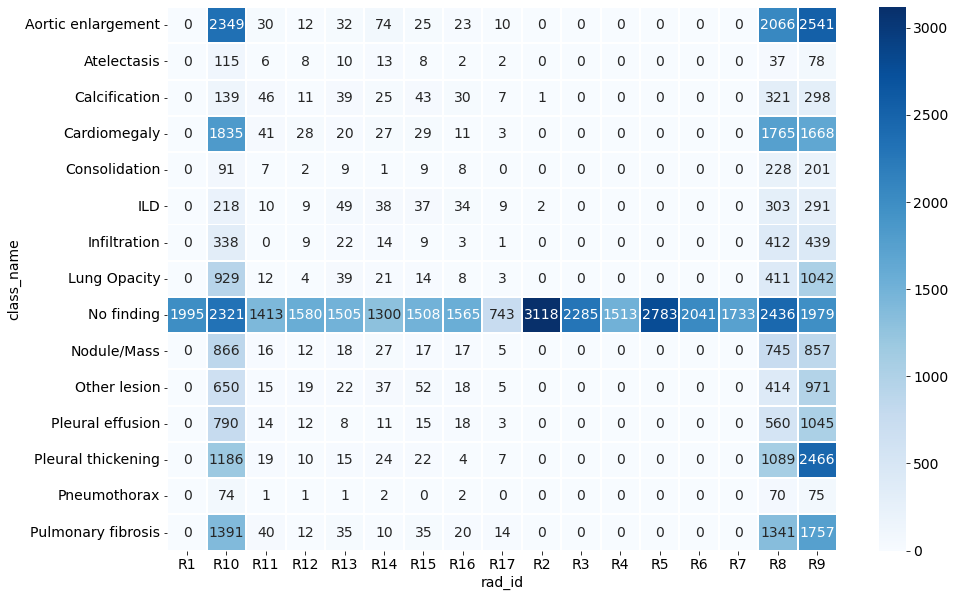

In [59]:
class_each_rad = pd.pivot_table(train_df, columns='rad_id', index='class_name',
                                values='image_id', aggfunc='count', fill_value=0)
plt.subplots(figsize=(15, 10))
sns.heatmap(class_each_rad, annot=True, linewidths=1, cmap='Blues', fmt='g')
plt.show()

Summary:
- R8, R9, R10 is predominant
- R1-7 is normal 


In [60]:
%%time

train_normal = train_df[train_df['class_name']=='No finding'].reset_index(drop=True)
train_normal['x_min_resize'] = 0
train_normal['y_min_resize'] = 0
train_normal['x_max_resize'] = 1
train_normal['y_max_resize'] = 1

train_abnormal = train_df[train_df['class_name']!='No finding'].reset_index(drop=True)
train_abnormal[['x_min_resize', 'y_min_resize', 'x_max_resize', 'y_max_resize']] = train_abnormal \
.apply(lambda x: label_resize(x[['h', 'w']].values, IMG_SIZE, *x[['x_min', 'y_min', 'x_max', 'y_max']].values),
       axis=1, result_type="expand")
train_abnormal['x_center'] = 0.5*(train_abnormal['x_min_resize'] + train_abnormal['x_max_resize'])
train_abnormal['y_center'] = 0.5*(train_abnormal['y_min_resize'] + train_abnormal['y_max_resize'])
train_abnormal['width'] = train_abnormal['x_max_resize'] - train_abnormal['x_min_resize']
train_abnormal['height'] = train_abnormal['y_max_resize'] - train_abnormal['y_min_resize']
train_abnormal['area'] = train_abnormal.apply(lambda x: (x['x_max_resize']-x['x_min_resize'])*(x['y_max_resize']-x['y_min_resize']), axis=1)
train_abnormal = train_abnormal[~train_abnormal.index.isin(list_remove)].reset_index(drop=True)


CPU times: user 28.3 s, sys: 0 ns, total: 28.3 s
Wall time: 28.3 s


In [61]:
train_abnormal.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,h,w,x_min_resize,y_min_resize,x_max_resize,y_max_resize,x_center,y_center,width,height,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2336,2080,170,301,407,401,288.5,351.0,237,100,23700
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2880,2304,281,132,358,181,319.5,156.5,77,49,3773
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,3072,2540,126,60,191,72,158.5,66.0,65,12,780
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2555,2285,302,49,490,435,396.0,242.0,188,386,72568
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,3353,2568,111,359,135,379,123.0,369.0,24,20,480


# Change bwf

In [62]:
def Preprocess_wbf(df, size=SIZE, iou_thr=0.5, skip_box_thr=0.0001):
    list_image = []
    list_boxes = []
    list_cls = []
    list_h, list_w = [], []
    new_df = pd.DataFrame()
    for image_id in tqdm(df['image_id'].unique(), leave=False):
        image_df = df[df['image_id']==image_id].reset_index(drop=True)
        h, w = image_df.loc[0, ['h', 'w']].values
        boxes = image_df[['x_min_resize', 'y_min_resize',
                          'x_max_resize', 'y_max_resize']].values.tolist()
        boxes = [[j/(size-1) for j in i] for i in boxes]
        scores = [1.0]*len(boxes)
        labels = [float(i) for i in image_df['class_id'].values]
        boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels],
                                                      weights=None,
                                                      iou_thr=iou_thr,
                                                      skip_box_thr=skip_box_thr)
        list_image.extend([image_id]*len(boxes))
        list_h.extend([h]*len(boxes))
        list_w.extend([w]*len(boxes))
        list_boxes.extend(boxes)
        list_cls.extend(labels.tolist())
    list_boxes = [[int(j*(size-1)) for j in i] for i in list_boxes]
    new_df['image_id'] = list_image
    new_df['class_id'] = list_cls
    new_df['h'] = list_h
    new_df['w'] = list_w
    new_df['x_min_resize'], new_df['y_min_resize'], \
    new_df['x_max_resize'], new_df['y_max_resize'] = np.transpose(list_boxes)
    new_df['x_center'] = 0.5*(new_df['x_min_resize'] + new_df['x_max_resize'])
    new_df['y_center'] = 0.5*(new_df['y_min_resize'] + new_df['y_max_resize'])
    new_df['width'] = new_df['x_max_resize'] - new_df['x_min_resize']
    new_df['height'] = new_df['y_max_resize'] - new_df['y_min_resize']
    new_df['area'] = new_df.apply(lambda x: (x['x_max_resize']-x['x_min_resize'])\
                                  *(x['y_max_resize']-x['y_min_resize']), axis=1)
    return new_df


In [63]:
train_abnormal = Preprocess_wbf(train_abnormal)
train_abnormal.tail()

  0%|          | 0/4394 [00:00<?, ?it/s]

,image_id,class_id,h,w,x_min_resize,y_min_resize,x_max_resize,y_max_resize,x_center,y_center,width,height,area
23773,be53fe5a49231f1c1be020b0bdd8561f,6.0,2880,2304,98,196,149,226,123.5,211.0,51,30,1530
23774,380d07a94cc4b012812119370de47192,0.0,2368,1864,288,142,354,199,321.0,170.5,66,57,3762
23775,52951d7de2485aba8ed62629eee4d254,9.0,2880,2304,67,256,85,268,76.0,262.0,18,12,216
23776,52951d7de2485aba8ed62629eee4d254,3.0,2880,2304,160,286,359,340,259.5,313.0,199,54,10746
23777,1224f07d895107573588225f692e94f9,0.0,2264,2040,258,157,319,220,288.5,188.5,61,63,3843


#Fold